<a href="https://colab.research.google.com/github/delffine/Pet-projects/blob/main/test_tasks/devim/devim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вводная информация

Дано три датасета по выдачам кредитов и платежам: договоры, план выплат, фактические платежи[»](fix::). Данные актуальны на 08.12.2022. Задача: проанализировать характер поведения клиентов с точки зрения просрочки: какая динамика просрочки, наблюдается ли рост или снижение?

Просрочка — это нарушение должником сроков и/или объёмов исполнения обязательств, предусмотренных договором (графиком платежей).

Описание колонок:
- order_id – номер заявки
- created_at - дата создания заявки
- put_at - дата выдачи
- closed_at - дата закрытия
- issued_sum - сумма выдачи
- plan_at - дата планового платежа
- plan_sum_total - сумма планового платежа (накопленным итогом)
- paid_at - дата фактического платежа
- paid_sum - сумма фактического платежа



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Загрузка данных

In [ ]:
#Данные для аналза хранятся в excel файле на google.disc
#Подлючаем google.disc как папку
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/devim/'):
  from google.colab import drive
  drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/devim/

/content/drive/My Drive/Colab Notebooks/devim


In [ ]:
orders = pd.read_csv('data/orders.csv')
payments = pd.read_csv('data/payments.csv')
plan = pd.read_csv('data/plan.csv')

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55748 entries, 0 to 55747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    55748 non-null  int64  
 1   created_at  55748 non-null  object 
 2   put_at      55748 non-null  object 
 3   closed_at   46472 non-null  object 
 4   issued_sum  55748 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.1+ MB


In [ ]:
plan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420282 entries, 0 to 420281
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        420282 non-null  int64  
 1   plan_at         420282 non-null  object 
 2   plan_sum_total  420282 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.6+ MB


In [ ]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143284 entries, 0 to 143283
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   order_id  143284 non-null  int64  
 1   paid_at   143284 non-null  object 
 2   paid_sum  143284 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.3+ MB


In [ ]:
orders.head()

,order_id,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0


In [ ]:
plan.head()

,order_id,plan_at,plan_sum_total
0,400001732,2022-06-02,5600.0
1,400001732,2022-07-02,9450.0
2,400001732,2022-08-01,12170.0
3,400001732,2022-08-31,14890.0
4,400001732,2022-09-30,17610.0


In [ ]:
payments.head()

,order_id,paid_at,paid_sum
0,400013633,2022-06-02 00:48:13.800,2500.0
1,400018480,2022-06-02 01:52:05.707,1070.0
2,400032001,2022-06-02 04:55:40.307,4200.0
3,400033195,2022-06-02 05:44:23.480,2850.0
4,400039407,2022-06-02 06:53:54.503,10100.0


# Предобработка

Проверяем дубликаты

In [ ]:
print(orders.duplicated().sum())
print(plan.duplicated().sum())
print(payments.duplicated().sum())

0
0
5


В платежах пять полных дубликатов... удаляем

In [ ]:
payments = payments.drop_duplicates()

Пропуски, судя по info(), только в колонке closed_at датасета с договорами. Очевидно, это не закрытые договора.
Заполнить их заглушкой - заведомо большой датой. Приводим все колонки с датами к типу дата

In [ ]:
orders['created_at_dt'] = pd.to_datetime(orders['created_at']).dt.date
orders['put_at_dt'] = pd.to_datetime(orders['put_at']).dt.date
orders['closed_at'] = orders['closed_at'].fillna('2099-01-01 00:00:00.000')
orders['closed_at_dt'] = pd.to_datetime(orders['closed_at']).dt.date

plan['plan_at_dt'] = pd.to_datetime(plan['plan_at']).dt.date
payments['paid_at_dt'] = pd.to_datetime(payments['paid_at']).dt.date

# Динамика заявок и выдачи кредитов

In [ ]:
create_dinamik = orders.groupby('created_at_dt').agg({'order_id' : 'count', 'issued_sum' : 'sum'})
put_dinamik = orders.groupby('put_at_dt').agg({'order_id' : 'count', 'issued_sum' : 'sum'})

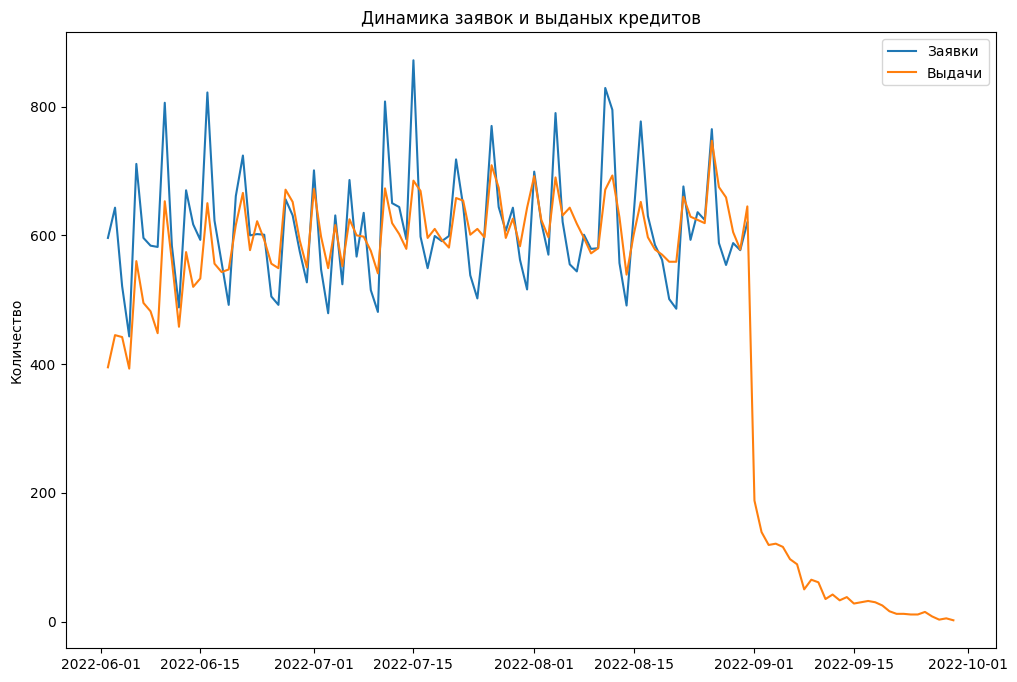

In [ ]:
fig = plt.figure(figsize = (12, 8))
plt.plot(create_dinamik['order_id'], color='tab:blue', label='Заявки')
plt.plot(put_dinamik['order_id'], color='tab:orange', label='Выдачи')
plt.title('Динамика заявок и выданых кредитов')
plt.ylabel('Количество')
plt.legend()
plt.show()

Сразу видно резкое в сентябре - падение как заявок, так и выданных кредитов.

In [ ]:
pay_dinamik = payments.groupby('paid_at_dt').agg({'order_id' : 'count', 'paid_sum' : 'sum'})

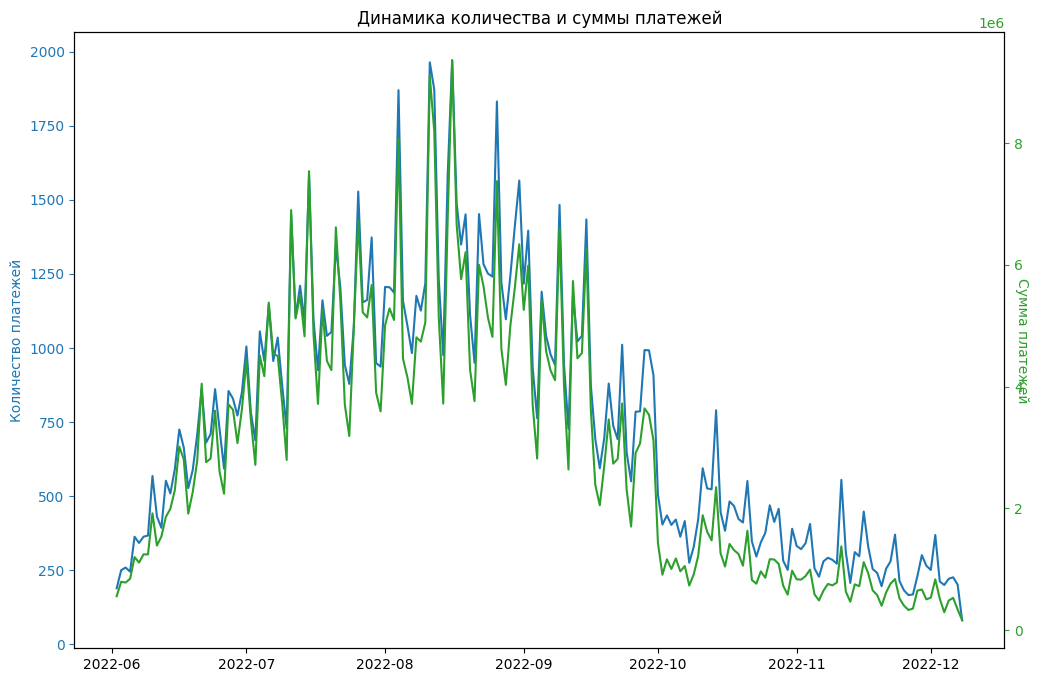

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))
ax1 = ax.twinx()
ax.plot(pay_dinamik['order_id'], color='tab:blue', label='Количество платежей')
ax.tick_params(axis='y', colors="tab:blue")
ax.set_ylabel('Количество платежей', color="tab:blue")

ax1.plot(pay_dinamik['paid_sum'], color='tab:green', label='Сумма платежей')
ax1.tick_params(axis='y', colors="tab:green")
ax1.set_ylabel('Сумма платежей', rotation=-90, color="tab:green")

plt.title('Динамика количества и суммы платежей')
plt.show()

Волновой характер динамики платежей, очевидно, обусловлен днями недели.

In [ ]:
#Процедура вывода динамики платежей по конкретному кредиту
# or_id - номер договора кредита
def dinamik_order (or_id):
    o_test = orders.query('order_id == @or_id')
    pl_test = plan.query('order_id == @or_id').sort_values(by='plan_at_dt')
    p_test = payments.query('order_id == @or_id').sort_values(by='paid_at_dt')
    full_sum = pl_test['plan_sum_total'].max()
    close_dt = o_test['closed_at_dt'].iloc[0]
    p_test['paid_total'] = p_test['paid_sum'].cumsum()
    print()
    print(f' ------- Динамика платежей по договору {or_id} -------- ')
    print(f'Заявка от {o_test["created_at_dt"].iloc[0]}')
    print(f'Выдано {o_test["put_at_dt"].iloc[0]}')
    print(f'Полная сумма кредита {full_sum:.0f}')
    for i in range(0, len(pl_test)):
        plt_tt = pl_test.iloc[i]['plan_at_dt']
        plt_ss = pl_test.iloc[i]['plan_sum_total']

        if close_dt < plt_tt:
            print(f'Закрытие кредита {close_dt}')
            break

        fact_on_date = p_test.query('paid_at_dt <= @plt_tt').sort_values(by='paid_at_dt', ascending=False).head(1)
        fact_ss = 0
        if len(fact_on_date) > 0 :
            fact_ss = fact_on_date.iloc[0]['paid_total']
            if fact_ss < plt_ss:
                prosrochka = 'Есть просрочка!'
            elif fact_ss == full_sum:
                prosrochka = 'Все выплачено!'
            elif fact_ss > plt_ss * 1.1:
                prosrochka = 'Опережение > 10%'
            else:
                prosrochka = 'Нет просрочки'
        else:
            prosrochka = 'Нет платежей!'

        print(f'На дату {plt_tt} план {plt_ss:.0f} факт {fact_ss:.0f}, {prosrochka}')

In [ ]:
#Выведем динамики платежей 5 случайных кредитов
oo = orders.sample(5)
for o in range(0, len(oo)):
    order = oo.iloc[o]['order_id']
    dinamik_order(order)


 ------- Динамика платежей по договору 479340398 -------- 
Заявка от 2022-08-16
Выдано 2022-09-04
Полная сумма кредита 8050
Закрытие кредита 2022-09-15

 ------- Динамика платежей по договору 458537533 -------- 
Заявка от 2022-07-27
Выдано 2022-07-27
Полная сумма кредита 2916
На дату 2022-07-27 план 720 факт 0, Нет платежей!
На дату 2022-08-26 план 1190 факт 0, Нет платежей!
На дату 2022-09-25 план 1534 факт 1190, Есть просрочка!
На дату 2022-10-25 план 1880 факт 1190, Есть просрочка!
На дату 2022-11-24 план 2228 факт 1880, Есть просрочка!
На дату 2022-12-24 план 2572 факт 1880, Есть просрочка!
На дату 2023-01-23 план 2916 факт 1880, Есть просрочка!

 ------- Динамика платежей по договору 427320532 -------- 
Заявка от 2022-06-28
Выдано 2022-06-28
Полная сумма кредита 8050
На дату 2022-07-13 план 8050 факт 8050, Все выплачено!

 ------- Динамика платежей по договору 458559768 -------- 
Заявка от 2022-07-27
Выдано 2022-08-09
Полная сумма кредита 8920
На дату 2022-08-09 план 1430 факт 14

# Алгоритм оценки ситуации с кредитами на заданную дату

Задаем дату

In [ ]:
test_date = pd.to_datetime('2022-07-01').date()
test_date

datetime.date(2022, 7, 1)

Выбираем договора, которые закончились на заданную дату

In [ ]:
closed_orders = orders.query('closed_at_dt <= @test_date')['order_id']

Выбираем планы на заданную дату, кроме договор, которые закончились

In [ ]:
plan_on_date = plan.query('plan_at_dt == @test_date and ~order_id.isin(@closed_orders)')

Ключевая операция: на основе таблицы платежей строим таблицу с платежами нарастанием. в "окне" договоров

In [ ]:
payments_day = payments.groupby(['order_id', 'paid_at_dt'])['paid_sum'].sum()
payments_cumsum = payments_day.groupby(level=0).cumsum()
payments_total = pd.merge(payments_day, payments_cumsum, how='outer', left_index=True, right_index= True).reset_index()
payments_total = payments_total.rename(columns = {'paid_sum_x': 'pay_one', 'paid_sum_y': 'payments_total'})

#проверяем на пропуски
print(payments_total.isna().sum().sum())

#проверка на случайным договоре
payments_total.query('order_id == '+ str(payments_total.sample(1)['order_id'].iloc[0]))

0


,order_id,paid_at_dt,pay_one,payments_total
50013,434686073,2022-07-05,3580.00,3580.00
50014,434686073,2022-07-15,435.21,4015.21
50015,434686073,2022-07-29,987.63,5002.84
50016,434686073,2022-08-16,867.26,5870.10
50017,434686073,2022-09-01,691.34,6561.44
50018,434686073,2022-09-15,682.08,7243.52
50019,434686073,2022-09-27,672.82,7916.34
50020,434686073,2022-10-14,3098.73,11015.07


Берем для договоров из таблицы платежей нарастанием последний платеж на дату, меньше заданной

In [ ]:
#payments_on_date = payments_total.query('paid_at_dt <= @test_date').groupby('order_id', as_index=False)['payments_total'].max()
payments_on_date = payments_total.query('paid_at_dt <= @test_date').groupby('order_id', as_index=False)['payments_total'].last()

Присоедияем к планам последние платежи нарастанием по номеру договора

In [ ]:
plpa_on_date = pd.merge(plan_on_date, payments_on_date, how='left', on ='order_id')
#Заменяем пропуски (это где нет платежей) - нулями
plpa_on_date = plpa_on_date.fillna(0)

Вычислеям разницу между планом и фактическими платежами

In [ ]:
plpa_on_date['delta'] = plpa_on_date['plan_sum_total'] - plpa_on_date['payments_total']

Выводм итоговую оценку ситуации с кредитами на заданную дату

In [ ]:
ondate = pd.DataFrame([])
#Просрочки с дельтой больше 0
ondate.loc[test_date, ['ov_sum', 'ov_co']] = plpa_on_date.query('delta > 0')\
    .agg({'delta' : 'sum', 'order_id' : 'count'})\
    .rename({'delta' : 'ov_sum', 'order_id' : 'ov_co'})

#Опережение - с дельтой меньше 0
ondate.loc[test_date, ['ex_sum', 'ex_co']] = plpa_on_date.query('delta < 0')\
    .agg({'delta' : 'sum', 'order_id' : 'count'})\
    .rename({'delta' : 'ex_sum', 'order_id' : 'ex_co'})
#Отбрасываем минус
ondate.loc[test_date,'ex_sum'] = abs(ondate.loc[test_date,'ex_sum'])

#По плану с дельтой равно 0
ondate.loc[test_date, 'on_plan'] = plpa_on_date.query('delta == 0').agg({'order_id' : 'count'})[0]
ondate

,ov_sum,ov_co,ex_sum,ex_co,on_plan
2022-07-01,1115895.4,375.0,45965.01,27.0,458.0


# Построение таблицы просрочек по дням

Тот же алгоритм в виде процедуры

In [ ]:
#процедура вычисления просрочки на дату
# day - дата
# cr_plan - таблица плана
# cr_pay - таблица платежей
# cr_or - таблица договоров
def overdue_on_date(day, cr_plan, cr_pay, cr_or):
    date = pd.to_datetime(day).date()

    #выбираем договора, которые закончились на заданную дату
    closed_orders = orders.query('closed_at_dt <= @date')['order_id']

    #выбираем планы на заданную дату, кроме договоров, которые закончились
    cr_plan_on_date = cr_plan.query('plan_at_dt == @date and ~order_id.isin(@closed_orders)')

    #на основе таблицы платежей строим таблицу с платежами нарастанием. в "окне" договоров
    pay_total = cr_pay.groupby(['order_id', 'paid_at_dt'])['paid_sum'].sum().groupby(level=0).cumsum().reset_index()
    pay_total = pay_total.rename(columns = {'paid_sum': 'payments_total'})

    #берем для договоров из таблицы платежей нарастанием максимальную сумму на заданную дату
    pay_on_date = pay_total.query('paid_at_dt <= @date').groupby('order_id', as_index=False)['payments_total'].max()

    #присоедияем к планам максимальные платежи нарастанием по номеру договора
    plpa_on_date = pd.merge(cr_plan_on_date, pay_on_date, how='left', on ='order_id')

    #Пропуски в платежах заменяем на нули
    plpa_on_date = plpa_on_date.fillna(0)

    #Считаем разницу между планом и фактическими платежами
    plpa_on_date['delta'] = plpa_on_date['plan_sum_total'] - plpa_on_date['payments_total']

    #Создаем выводную таблицу
    ondate = pd.DataFrame(columns = ['overdue_sum', 'overdue_count', 'exceeding_sum', 'exceeding_count', 'onplan_count'])

    #Просрочки с дельтой больше 0
    ondate.loc[date] = plpa_on_date.query('delta > 0')\
        .agg({'delta' : 'sum', 'order_id' : 'count'})\
        .rename({'delta' : 'overdue_sum', 'order_id' : 'overdue_count'})

    #Опережение - с дельтой меньше 0
    ondate.loc[date, ['exceeding_sum', 'exceeding_count']] = plpa_on_date.query('delta < 0')\
        .agg({'delta' : 'sum', 'order_id' : 'count'})\
        .rename({'delta' : 'exceeding_sum', 'order_id' : 'exceeding_count'})
    ondate.loc[date,'exceeding_sum'] = abs(ondate.loc[date,'exceeding_sum'])

    #По плану с дельтой равно 0
    ondate.loc[date, 'onplan_count'] = plpa_on_date.query('delta == 0').agg({'order_id' : 'count'})[0]
    return ondate

In [ ]:
#тестируем по заданной дате
overdue_on_date(test_date, plan, payments, orders)

,overdue_sum,overdue_count,exceeding_sum,exceeding_count,onplan_count
2022-07-01,1115895.4,375.0,45965.01,27.0,458.0


In [ ]:
#цикл построения таблицы просрочке по всем датам платежей
dates = sorted(payments['paid_at_dt'].unique())
overdue_table = pd.DataFrame([])
for i in range(0, len(dates)):
    dd = dates[i]
    overdue_table = pd.concat([overdue_table, overdue_on_date(dd, plan, payments, orders)])
overdue_table.head(5)

,overdue_sum,overdue_count,exceeding_sum,exceeding_count,onplan_count
2022-06-02,142110.0,63.0,6370.0,3.0,174.0
2022-06-03,119800.0,56.0,12935.0,6.0,202.0
2022-06-04,147510.0,65.0,16145.0,6.0,206.0
2022-06-05,153480.0,62.0,2165.0,2.0,194.0
2022-06-06,197800.0,93.0,19975.0,9.0,258.0


# Динамика просрочек по кредитам

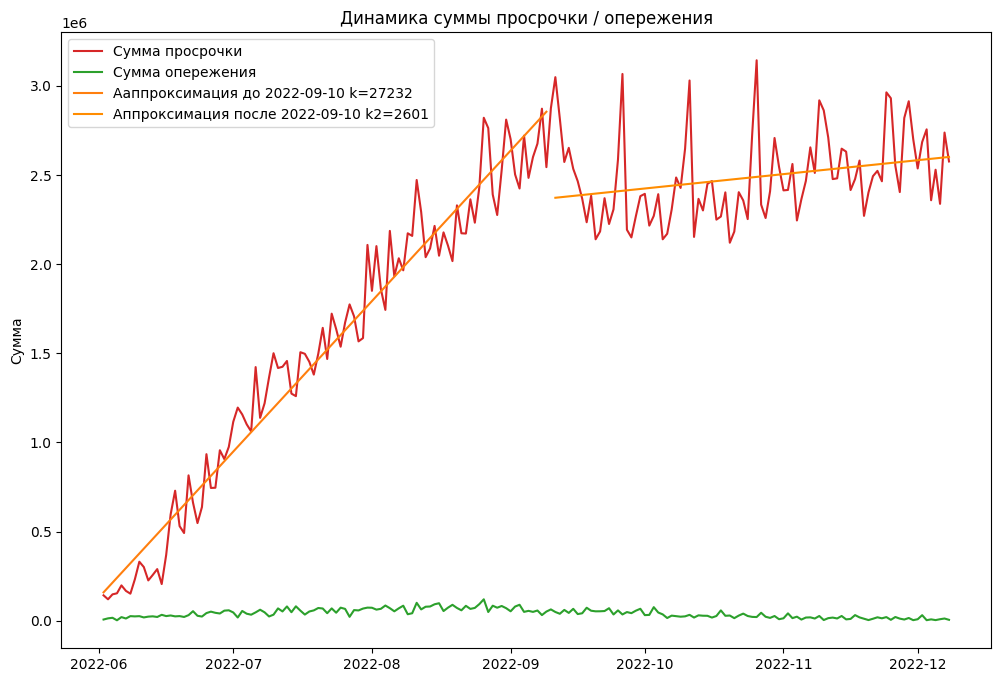

In [ ]:
fig = plt.figure(figsize = (12, 8))
plt.plot(overdue_table['overdue_sum'], color='tab:red', label='Сумма просрочки')
plt.plot(overdue_table['exceeding_sum'], color='tab:green', label='Сумма опережения')

stop_date = pd.to_datetime('2022-09-10').date()
rost = overdue_table.reset_index().rename(columns={'index' : 'date'}).query('date < @stop_date')
z = np.polyfit(rost.index, rost['overdue_sum'], 1)
p = np.poly1d(z)
plt.plot(rost['date'], p(rost.index), color='tab:orange', label = f'Ааппроксимация до {stop_date} k={z[0]:.0f}')

stop_date = pd.to_datetime('2022-09-10').date()
rost = overdue_table.reset_index().rename(columns={'index' : 'date'}).query('date > @stop_date')
z2 = np.polyfit(rost.index, rost['overdue_sum'], 1)
p2 = np.poly1d(z2)
plt.plot(rost['date'], p2(rost.index), color='darkorange', label = f'Аппроксимация после {stop_date} k2={z2[0]:.0f}')


plt.title('Динамика суммы просрочки / опережения')
plt.ylabel('Сумма')
plt.legend()
plt.show()

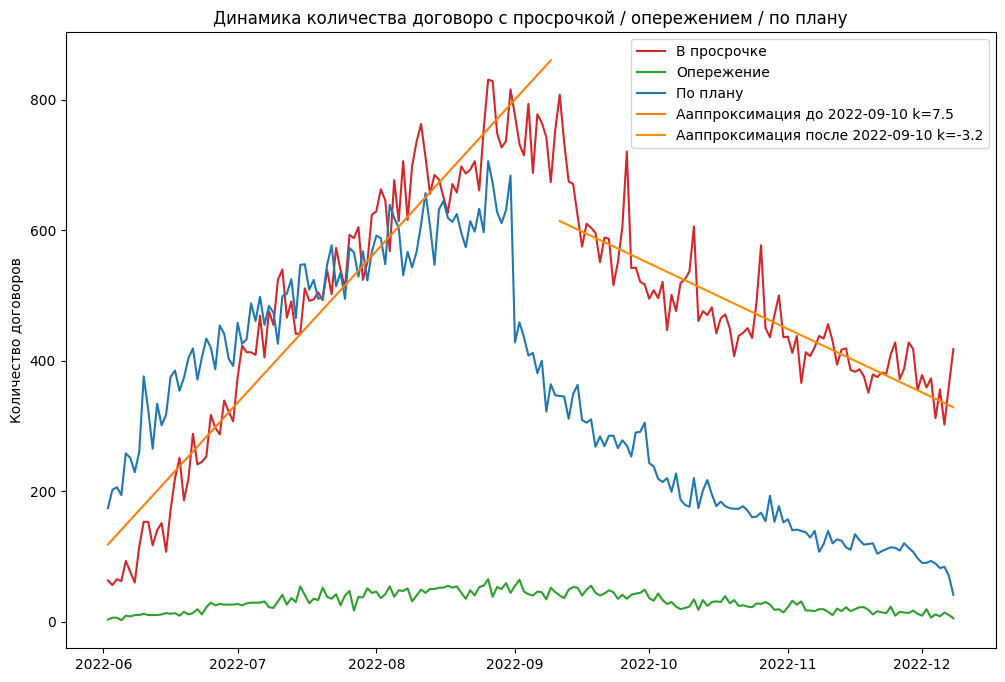

In [ ]:
fig = plt.figure(figsize = (12, 8))
plt.plot(overdue_table['overdue_count'], color='tab:red', label='В просрочке')
plt.plot(overdue_table['exceeding_count'], color='tab:green', label='Опережение')
plt.plot(overdue_table['onplan_count'], color='tab:blue', label='По плану')

stop_date = pd.to_datetime('2022-09-10').date()
rost = overdue_table.reset_index().rename(columns={'index' : 'date'}).query('date < @stop_date')
z = np.polyfit(rost.index, rost['overdue_count'], 1)
p = np.poly1d(z)
plt.plot(rost['date'], p(rost.index), color='tab:orange', label = f'Ааппроксимация до {stop_date} k={z[0]:.1f}')

stop_date = pd.to_datetime('2022-09-10').date()
rost = overdue_table.reset_index().rename(columns={'index' : 'date'}).query('date > @stop_date')
z2 = np.polyfit(rost.index, rost['overdue_count'], 1)
p2 = np.poly1d(z2)
plt.plot(rost['date'], p2(rost.index), color='darkorange', label = f'Ааппроксимация после {stop_date} k={z2[0]:.1f}')


plt.title('Динамика количества договоро с просрочкой / опережением / по плану')
plt.ylabel('Количество договоров')
plt.legend()
plt.show()

# Выводы

Уровень просрочки по кредитам уверенно рос до сентября 2022 года. Средняя скорость роста просрочки — 28 тысяч рублей в день, по 7 договоров в день уходили в просрочку. Затем кредитная организация совсем прекратила прием новых заявок. Кредиты еще выдавались до октября, видимо, по уже полученным заявкам, но существенно меньше. Это позволило стабилизировать ситуацию. С сентября по декабрь 2022 количество просроченных договоров снизилось более чем в два раза — с 800 до 300. Сумма просрочки, можно сказать, стабилизировалась примерно на уровне 2,5 млн. Однако наблюдается небольшая тенденция к росту — в среднем на 2600 рублей в день.